In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix

DATADIR = r"./Brain-Tumor-Classification-DataSet-master/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [12]:
glimoa_train = os.listdir(DATADIR + "glioma_tumor")
men_train =  os.listdir(DATADIR + "meningioma_tumor")
notumor_train = os.listdir(DATADIR + "no_tumor")
pit_train =  os.listdir(DATADIR + "pituitary_tumor")

In [13]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
create_training_data()

In [14]:
X = []
y = []

IMG_SIZE = 150

for features,label in training_data:
    X.append(features)
    y.append(label)
#X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE)
#print(X.shape)
#X = X/255.0  
#X = X.reshape(-1,150,150,1)

In [16]:
X_train = np.array(X)
y_train = np.array(y)

In [28]:
X_train.shape

(2439, 150, 150)

Data Splitting

In [20]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train.reshape(2870, 150, 150,1))
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

In [33]:
X_train.shape

(2439, 150, 150)

Load EfficientNetB3

In [37]:
#print(y_train)
image_size = 150
#load EfficientNet
EfficientNet=EfficientNetB3(weights=None, include_top=False,input_shape=(image_size,image_size,1))

Training the model

In [38]:
#train the model
tf.random.set_seed(45)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(lr=0.001, decay=1e-6)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=15,
    batch_size=30,callbacks=early_stopping_cb)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 150, 150, 1)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_4 (Normalization  (None, 150, 150, 1)  3          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 77, 77, 144)  0          ['block2a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 38, 38, 144)  1296       ['block2a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 38, 38, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_a

 block2c_activation (Activation  (None, 38, 38, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_s

                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_se_excite (Multiply)   (None, 19, 19, 288)  0           ['block3b_activation[0][0]',     
                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 19, 19, 48)   13824       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_p

                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 10, 10, 288)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 10, 10, 96)   27648       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 10, 10, 96)  384         ['block4a_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block4c_drop (Dropout)         (None, 10, 10, 96)   0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 10, 10, 96)   0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 10, 10, 576)  55296       ['block4c_add[0][0]']            
                                                                                                  
 block4d_expand_bn (BatchNormal  (None, 10, 10, 576)  2304       ['block4d_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 10, 10, 576)  55296       ['block4e_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 10, 10, 576)  2304       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 10, 10, 576)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 10, 10, 576)  14400      ['block5a_expand_activation[0][0]
 D)       

 D)                                                              ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 10, 10, 816)  3264       ['block5c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5c_activation (Activation  (None, 10, 10, 816)  0          ['block5c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5c_se_squeeze (GlobalAver  (None, 816)         0           ['block5c_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block5e_activation (Activation  (None, 10, 10, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 816)         0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5e_se_squeeze[0][0]']     
                                                                                                  
 block5e_se_reduce (Conv2D)     (None, 1, 1, 34)     27778       ['block5e_se_reshape[0][0]']     
                                                                                                  
 block5e_s

                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 5, 5, 1392)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 5, 5, 232)    322944      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_p

 block6d_se_excite (Multiply)   (None, 5, 5, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
                                                                                                  
 block6d_project_conv (Conv2D)  (None, 5, 5, 232)    322944      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 5, 5, 232)   928         ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 5, 5, 232)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_a

 block6f_project_bn (BatchNorma  (None, 5, 5, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6f_drop (Dropout)         (None, 5, 5, 232)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 5, 5, 232)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 5, 5, 1392)   322944      ['block6f_add[0][0]']            
                                                                                                  
 block7a_e

 top_bn (BatchNormalization)    (None, 5, 5, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 5, 5, 1536)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_average_pooling2d_4 (Gl  (None, 1536)        0           ['top_activation[0][0]']         
 obalAveragePooling2D)                                                                            
                                                                                                  
 dropout_8 (Dropout)            (None, 1536)         0           ['global_average_pooling2d_4[0][0
                                                                 ]']                              
                                                                                                  
 dense_8 (

In [40]:
model.save('test_model_2.h5')

In [41]:
Predict = model.predict(X_test)

14/14 [==============================] - 40s 2s/step


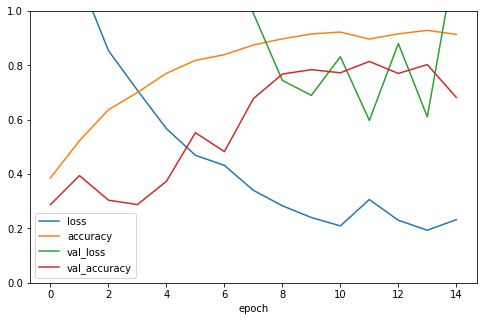

14/14 [==============================] - 11s 754ms/step - loss: 1.2124 - accuracy: 0.6821
Accuracy: 68.213457


In [51]:
#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.grid(True)

#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
plt.xlabel('epoch')
plt.show()#savefig('/kaggle/working/EfficientNetB3.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [43]:
#model.summary()
loss, accuracy = model.evaluate(X_test,y_test)

14/14 [==============================] - 33s 2s/step - loss: 1.2124 - accuracy: 0.6821


Accuracy and Loss

In [44]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 68.213 
 loss : 1.212


In [45]:
y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

14/14 [==============================] - 18s 1s/step


In [46]:
pd.Series(pred_labels).value_counts()

1    213
3    104
2     70
0     44
dtype: int64

In [47]:
import pandas as pd

y_pred = model.predict(X_test)
y_pred_array = np.argmax(y_pred, axis = 1) 
x={"y_test":y_test, "y_pred": y_pred_array}

df4 = pd.DataFrame(x)
df4.head(10)

14/14 [==============================] - 20s 1s/step


,y_test,y_pred
0,3,3
1,1,1
2,0,1
3,1,1
4,2,2
5,1,1
6,3,3
7,1,1
8,3,3
9,3,1


Confusion Matrix

Text(70.8, 0.5, 'Predicted class')

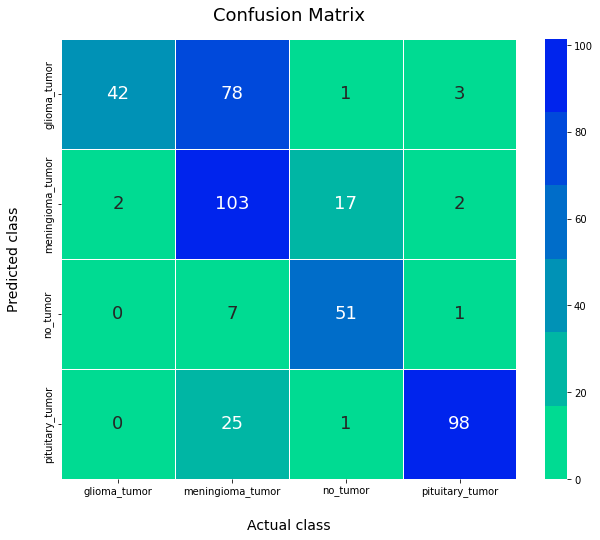

In [48]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test,pred,target_names=CATEGORIES))

                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.34      0.50       124
meningioma_tumor       0.48      0.83      0.61       124
        no_tumor       0.73      0.86      0.79        59
 pituitary_tumor       0.94      0.79      0.86       124

        accuracy                           0.68       431
       macro avg       0.78      0.71      0.69       431
    weighted avg       0.78      0.68      0.68       431

